In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0604/weights_KD_segformer_0604_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.9
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0049

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 628ms/step - loss: 0.0034
Average validation loss: 0.668067216873169
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 644ms/step - loss: 0.0034 - val_loss: 0.6681
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 811ms/step - loss: 0.0022 - val_loss: 0.6681
Average validation loss: 0.569037675857544
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 827ms/step - loss: 0.0022 - val_loss: 0.6186
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 811ms/step - loss: 0.0016 - val_loss: 0.6186
Average validation loss: 0.5047731995582581
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 827ms/step - loss: 0.0016 - val_loss: 0.5806
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segfo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 827ms/step - loss: 2.6138e-06
Average validation loss: 0.19910871982574463
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 836ms/step - loss: 2.6138e-06 - val_loss: 0.1991
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 803ms/step - loss: 2.5804e-06 - val_loss: 0.1991
Average validation loss: 0.16164704412221909
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 812ms/step - loss: 2.5804e-06 - val_loss: 0.1804
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 798ms/step - loss: 2.5090e-06 - val_loss: 0.1804
Average validation loss: 0.21994475275278091
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 811ms/step - loss: 2.5090e-06 - val_loss: 0.1936
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 820ms/step - loss: 2.4343e-06 - val_loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 835ms/step - loss: 1.5139e-06
Average validation loss: 0.06224167595307032
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 844ms/step - loss: 1.5139e-06 - val_loss: 0.0622
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 835ms/step - loss: 1.3630e-06 - val_loss: 0.0622
Average validation loss: 0.04941630115111669
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 846ms/step - loss: 1.3630e-06 - val_loss: 0.0558
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 844ms/step - loss: 1.2681e-06 - val_loss: 0.0558
Average validation loss: 0.044806854178508125
12/12 ━━━━━━━━━━━━━━━━━━━━ 30s 855ms/step - loss: 1.2681e-06 - val_loss: 0.0522
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\we

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 837ms/step - loss: 5.1297e-07
Average validation loss: 0.028589306864887476
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 849ms/step - loss: 5.1297e-07 - val_loss: 0.0286
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 799ms/step - loss: 5.3749e-07 - val_loss: 0.0286
Average validation loss: 0.03006742859724909
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 809ms/step - loss: 5.3749e-07 - val_loss: 0.0293
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 796ms/step - loss: 5.1406e-07 - val_loss: 0.0293
Average validation loss: 0.04563123430125415
16/16 ━━━━━━━━━━━━━━━━━━━━ 39s 806ms/step - loss: 5.1406e-07 - val_loss: 0.0348
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 798ms/step - loss: 5.0851e-07 - val_loss: 0.0348
Average validation loss: 0.02131907909642905
16/16 ━━━━━━━━━━━━━━━━━━━━ 52s 809ms/step - loss: 5.0851e-07 - val_loss: 0.0314
Saved mo

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 824ms/step - loss: 2.9423e-07
Average validation loss: 0.019686138536781073
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 837ms/step - loss: 2.9423e-07 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 772ms/step - loss: 2.8968e-07 - val_loss: 0.0197
Average validation loss: 0.020609966665506362
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 785ms/step - loss: 2.8968e-07 - val_loss: 0.0201
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 776ms/step - loss: 2.8723e-07 - val_loss: 0.0201
Average validation loss: 0.04300151290372014
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 790ms/step - loss: 2.8723e-07 - val_loss: 0.0278
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 63s 776ms/step - loss: 2.6871e-07 - val_loss: 0.0278
Average validation loss: 0.018282678723335267
20/20 ━━━━━━━━━━━━━━━━━━━━ 64s 790ms/step - loss: 2.6871e-07 - val_loss: 0.0254
Saved 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 818ms/step - loss: 3.8229e-07
Average validation loss: 0.03854388406034559
24/24 ━━━━━━━━━━━━━━━━━━━━ 20s 831ms/step - loss: 3.8229e-07 - val_loss: 0.0385
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 774ms/step - loss: 3.2543e-07 - val_loss: 0.0385
Average validation loss: 0.018258968329367537
24/24 ━━━━━━━━━━━━━━━━━━━━ 39s 787ms/step - loss: 3.2543e-07 - val_loss: 0.0284
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 774ms/step - loss: 2.7428e-07 - val_loss: 0.0284
Average validation loss: 0.014075233203281337
24/24 ━━━━━━━━━━━━━━━━━━━━ 58s 788ms/step - loss: 2.7428e-07 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\w

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 793ms/step - loss: 4.8738e-07
Average validation loss: 0.018662680685520173
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 804ms/step - loss: 4.8738e-07 - val_loss: 0.0187
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 768ms/step - loss: 4.3758e-07 - val_loss: 0.0187
Average validation loss: 0.021656380430795253
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 778ms/step - loss: 4.3758e-07 - val_loss: 0.0202
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 776ms/step - loss: 3.8568e-07 - val_loss: 0.0202
Average validation loss: 0.018267911998555063
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 787ms/step - loss: 3.8568e-07 - val_loss: 0.0195
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_50.pth'.
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 126s 777ms/step - loss: 3.4

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 773ms/step - loss: 2.3045e-07
Average validation loss: 0.01796799843820433
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 785ms/step - loss: 2.3045e-07 - val_loss: 0.0180
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 809ms/step - loss: 1.9283e-07 - val_loss: 0.0180
Average validation loss: 0.016145676869200543
48/48 ━━━━━━━━━━━━━━━━━━━━ 77s 821ms/step - loss: 1.9283e-07 - val_loss: 0.0171
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 115s 787ms/step - loss: 1.7256e-07 - val_loss: 0.0171
Average validation loss: 0.017664100295708824
48/48 ━━━━━━━━━━━━━━━━━━━━ 116s 799ms/step - loss: 1.7256e-07 - val_loss: 0.0173
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 154s 789ms/step - loss: 1.

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 45s 807ms/step - loss: 1.2417e-07
Average validation loss: 0.04188966262154281
56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 819ms/step - loss: 1.2417e-07 - val_loss: 0.0419
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 900ms/step - loss: 1.1701e-07 - val_loss: 0.0419
Average validation loss: 0.03764521423727274
56/56 ━━━━━━━━━━━━━━━━━━━━ 97s 912ms/step - loss: 1.1701e-07 - val_loss: 0.0398
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_70.pth'.
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 901ms/step - loss: 1.0599e-07 - val_loss: 0.0398
Average validation loss: 0.015751405535931035
56/56 ━━━━━━━━━━━━━━━━━━━━ 148s 912ms/step - loss: 1.0599e-07 - val_loss: 0.0318
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 54s 846ms/step - loss: 1.1228e-07
Average validation loss: 0.013214347156463191
64/64 ━━━━━━━━━━━━━━━━━━━━ 55s 857ms/step - loss: 1.1228e-07 - val_loss: 0.0132
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 105s 785ms/step - loss: 1.0214e-07 - val_loss: 0.0132
Average validation loss: 0.011812690165243112
64/64 ━━━━━━━━━━━━━━━━━━━━ 106s 796ms/step - loss: 1.0214e-07 - val_loss: 0.0125
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 156s 782ms/step - loss: 9.2324e-08 - val_loss: 0.0125
Average validation loss: 0.014775499847019091
64/64 ━━━━━━━━━━━━━━━━━━━━ 157s 794ms/step - loss: 9.2324e-08 - val_loss: 0.0133
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 208s 799ms/step - loss:

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 800ms/step - loss: 9.1882e-08
Average validation loss: 0.01970131906111621
72/72 ━━━━━━━━━━━━━━━━━━━━ 58s 811ms/step - loss: 9.1882e-08 - val_loss: 0.0197
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 115s 786ms/step - loss: 8.0290e-08 - val_loss: 0.0197
Average validation loss: 0.028772147922104016
72/72 ━━━━━━━━━━━━━━━━━━━━ 116s 797ms/step - loss: 8.0290e-08 - val_loss: 0.0242
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 172s 778ms/step - loss: 6.7989e-08 - val_loss: 0.0242
Average validation loss: 0.02057219201621289
72/72 ━━━━━━━━━━━━━━━━━━━━ 173s 789ms/step - loss: 6.7989e-08 - val_loss: 0.0230
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 229s 779ms/step - loss: 6.1552e-08 - val_loss: 0.0230
Average validation loss: 0.023496208201524697
72/72 ━━━━━━━━━━━━━━━━━━━━ 230s 790ms/step - loss: 6.1552e-08 - val_loss: 0.0231
E

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 789ms/step - loss: 1.0785e-07
Average validation loss: 0.01773181222670246
80/80 ━━━━━━━━━━━━━━━━━━━━ 64s 799ms/step - loss: 1.0785e-07 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 130s 829ms/step - loss: 8.6237e-08 - val_loss: 0.0177
Average validation loss: 0.01758126455824822
80/80 ━━━━━━━━━━━━━━━━━━━━ 131s 840ms/step - loss: 8.6237e-08 - val_loss: 0.0177
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 195s 795ms/step - loss: 7.4695e-08 - val_loss: 0.0177
Average validation loss: 0.01752201393537689
80/80 ━━━━━━━━━━━━━━━━━━━━ 196s 806ms/step - loss: 7.4695e-08 - val_loss: 0.0176
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 777ms/step - loss: 1.2123e-07
Average validation loss: 0.03055461776481631
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 787ms/step - loss: 1.2123e-07 - val_loss: 0.0306
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 150s 775ms/step - loss: 9.6347e-08 - val_loss: 0.0306
Average validation loss: 0.0224732434823333
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 786ms/step - loss: 9.6347e-08 - val_loss: 0.0265
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 779ms/step - loss: 8.2224e-08 - val_loss: 0.0265
Average validation loss: 0.028574514290085062
96/96 ━━━━━━━━━━━━━━━━━━━━ 227s 790ms/step - loss: 8.2224e-08 - val_loss: 0.0272
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 302s 780ms/step - loss: 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 93s 776ms/step - loss: 2.6844e-07
Average validation loss: 0.023641427520972987
120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 787ms/step - loss: 2.6844e-07 - val_loss: 0.0236
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 807ms/step - loss: 2.0591e-07 - val_loss: 0.0236
Average validation loss: 0.019228687960033616
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 818ms/step - loss: 2.0591e-07 - val_loss: 0.0214
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 289s 804ms/step - loss: 1.7145e-07 - val_loss: 0.0214
Average validation loss: 0.017560650175437332
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 815ms/step - loss: 1.7145e-07 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 781ms/step - loss: 1.6458e-07
Average validation loss: 0.02098357438808307
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 792ms/step - loss: 1.6458e-07 - val_loss: 0.0210
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 231s 808ms/step - loss: 1.6036e-07 - val_loss: 0.0210
Average validation loss: 0.023872741886104148
144/144 ━━━━━━━━━━━━━━━━━━━━ 232s 818ms/step - loss: 1.6036e-07 - val_loss: 0.0224
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 346s 794ms/step - loss: 1.4554e-07 - val_loss: 0.0224
Average validation loss: 0.023675187012284167
144/144 ━━━━━━━━━━━━━━━━━━━━ 348s 805ms/step - loss: 1.4554e-07 - val_loss: 0.0228
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 462s 791ms/step - loss: 1.2879e-07 - val_loss: 0.0228
Average validation loss: 0.01922804168942902
144/144 ━━━━━━━━━━━━━━━━━━━━ 463s 802ms/step - loss: 1.2879e-07 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 790ms/step - loss: 1.1237e-07
Average validation loss: 0.01819252024870366
160/160 ━━━━━━━━━━━━━━━━━━━━ 128s 801ms/step - loss: 1.1237e-07 - val_loss: 0.0182
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 257s 808ms/step - loss: 9.5500e-08 - val_loss: 0.0182
Average validation loss: 0.02237160603981465
160/160 ━━━━━━━━━━━━━━━━━━━━ 259s 819ms/step - loss: 9.5500e-08 - val_loss: 0.0203
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 386s 791ms/step - loss: 8.0961e-08 - val_loss: 0.0203
Average validation loss: 0.021380690718069674
160/160 ━━━━━━━━━━━━━━━━━━━━ 387s 802ms/step - loss: 8.0961e-08 - val_loss: 0.0206
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 517s 807ms/step - loss: 7.1127e-08 - val_loss: 0.0206
Average validation loss: 0.021846404869575054
160/160 ━━━━━━━━━━━━━━━━━━━━ 518s 818ms/step - loss: 7.1127e-08 -

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 788ms/step - loss: 1.5086e-07
Average validation loss: 0.019910377110354604
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 799ms/step - loss: 1.5086e-07 - val_loss: 0.0199
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 783ms/step - loss: 1.2475e-07 - val_loss: 0.0199
Average validation loss: 0.02061243772972375
200/200 ━━━━━━━━━━━━━━━━━━━━ 319s 794ms/step - loss: 1.2475e-07 - val_loss: 0.0203
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 482s 816ms/step - loss: 1.0710e-07 - val_loss: 0.0203
Average validation loss: 0.026323679763590915
200/200 ━━━━━━━━━━━━━━━━━━━━ 484s 826ms/step - loss: 1.0710e-07 - val_loss: 0.0223
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 644s 799ms/step - loss: 9.3551e-08 - val_loss: 0.0223
Average validation loss: 0.017451992724090815
200/200 ━━━━━━━━━━━━━━━━━━━━ 646s 810ms/step - loss: 9.3551e-08 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 790ms/step - loss: 9.6678e-08
Average validation loss: 0.01431532871890037
240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 801ms/step - loss: 9.6678e-08 - val_loss: 0.0143
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar0DB\weights/weights_KD_segformer_0604/weights_KD_segformer_0604_90\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 384s 797ms/step - loss: 7.8182e-08 - val_loss: 0.0143
Average validation loss: 0.016294981089110174
240/240 ━━━━━━━━━━━━━━━━━━━━ 386s 808ms/step - loss: 7.8182e-08 - val_loss: 0.0153
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 577s 795ms/step - loss: 6.9199e-08 - val_loss: 0.0153
Average validation loss: 0.015168694003174702
240/240 ━━━━━━━━━━━━━━━━━━━━ 580s 806ms/step - loss: 6.9199e-08 - val_loss: 0.0153
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 770s 794ms/step - loss: 6.3533e-08 - val_loss: 0.0153
Average validation loss: 0.02115567201205219
240/240 ━━━━━━━━━━━━━━━━━━━━ 773s 805ms/step - loss: 6.3533e-08 -

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.21416024677455425, 0.1034807310346514, 0.036890897390743096, 0.023921227593091315, 0.019590013872133567, 0.017751495606304766, 0.01963196850090753, 0.017280136389793675, 0.01690291423936807, 0.015489901866967557, 0.015332280901946231, 0.014742985258519184, 0.015737113771441123, 0.02008859318390023, 0.01871001846380144, 0.016952271157642824, 0.01787679030041909, 0.01676541905880246]
std_val_losses =  [0.17757804437175603, 0.07185502144837537, 0.016794548177487312, 0.010188808278742785, 0.009912697289868627, 0.009038124363127462, 0.008227651429129837, 0.004711281144524916, 0.006428320649031394, 0.003976816171208225, 0.0041721186741328796, 0.0026381012075323597, 0.006208769866741589, 0.0038284234430757853, 0.00300905407879645, 0.004104629335893026, 0.0027898472406947743, 0.0026967105191063037]


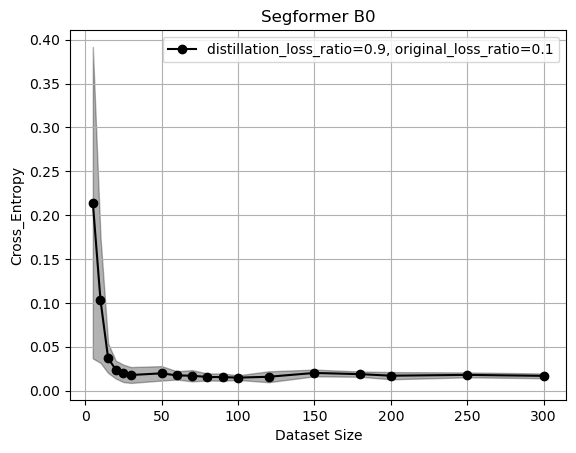

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0604')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0604_{int(teacher_ratio*100)}.png"))

plt.show()